In [7]:
import sympy as sp

# === 1. Generalized coordinates ===
t = sp.symbols('t', real=True)
phi = sp.Function('phi')(t)    # roll angle
delta = sp.Function('delta')(t)  # steering angle

# === 2. Parameters ===
m, g, h = sp.symbols('m g h', positive=True)         # mass, gravity, CG height
I_phi, I_delta = sp.symbols('I_phi I_delta', positive=True)  # roll & steering inertia
v = sp.symbols('v', real=True)                      # forward speed
c_coupling = sp.symbols('c_coupling', real=True)    # symbolic coupling coefficient

# === 3. Kinetic energy ===
T = (1/sp.Integer(2))*I_phi*sp.diff(phi, t)**2 + (1/sp.Integer(2))*I_delta*sp.diff(delta, t)**2

# === 4. Potential energy ===
V = (1/sp.Integer(2))*m*g*h*phi**2

# === 5. Lagrangian ===
L = T - V

# === 6. Generalized coordinates vector ===
q = [phi, delta]

# === 7. Lagrange's equations ===
eqns = []
for qi in q:
    dLdqi_dot = sp.diff(L, sp.diff(qi, t))
    ddt_dLdqi_dot = sp.diff(dLdqi_dot, t)
    dLdqi = sp.diff(L, qi)
    # Add symbolic velocity coupling term: c_coupling*v*delta_dot appears in roll eqn, etc.
    # For now, treat it as generalized non-conservative force Q_i
    Q_i = 0  # We will later add C*v*dot(q)
    eq = ddt_dLdqi_dot - dLdqi - Q_i
    eqns.append(sp.simplify(eq))

eqns


[I_phi*Derivative(phi(t), (t, 2)) + g*h*m*phi(t),
 I_delta*Derivative(delta(t), (t, 2))]

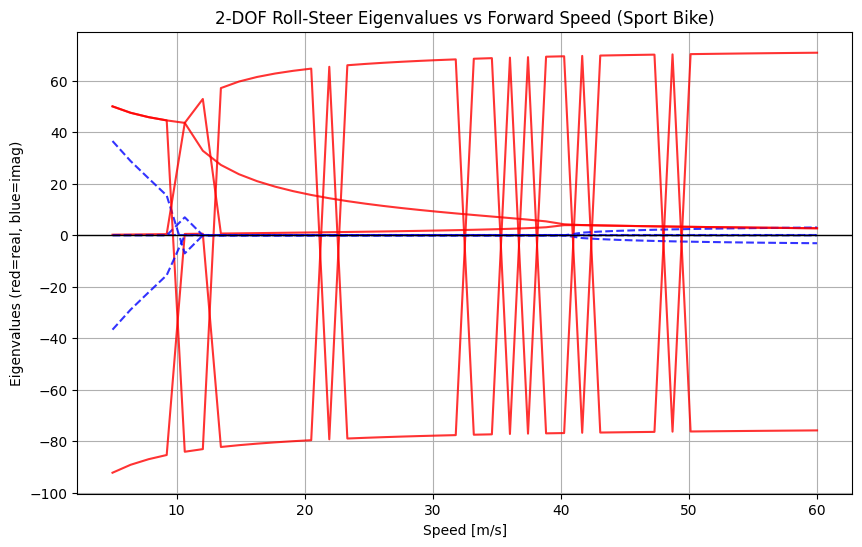

In [8]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# === 1. Symbolic parameters & state matrix ===
v_sym = sp.symbols('v', real=True)
m, g, h = sp.symbols('m g h', positive=True)
I_phi, I_delta = sp.symbols('I_phi I_delta', positive=True)
Cf, Cr = sp.symbols('C_f C_r', positive=True)
a, b, tr = sp.symbols('a b t_r', real=True)

# Physical M
M_phys = sp.Matrix([[I_phi, 0],
                    [0, I_delta]])

# Gravity stiffness
K_gravity = m*g*h

# Velocity-dependent coupling
C_known = sp.Matrix([
    [(Cf*a*h - Cr*b*h)/v_sym, 0],
    [-(Cf*a*tr)/v_sym, 0]
])
# Stiffness matrix
K_known = sp.Matrix([
    [K_gravity, Cf*h],
    [0, -Cf*tr]
])

# Build state matrix
Minv = M_phys.inv()
Z = sp.zeros(2)
I2 = sp.eye(2)
A_top = sp.Matrix.hstack(Z, I2)
A_bottom = sp.Matrix.hstack(-Minv*K_known, -Minv*C_known)
A_symbolic = sp.Matrix.vstack(A_top, A_bottom)

# === 2. Numerical sport bike parameters ===
params = {
    m: 250.0,
    g: 9.81,
    h: 0.55,
    I_phi: 80.0,
    I_delta: 1.0,
    Cf: 60000.0,
    Cr: 80000.0,
    a: 0.7,
    b: 0.6,
    tr: 0.09
}

# === 3. Speed sweep ===
speeds = np.linspace(5, 60, 40)  # m/s
eigvals_all = []

for v_val in speeds:
    subs_dict = params.copy()
    subs_dict[v_sym] = float(v_val)
    A_num = np.array(A_symbolic.subs(subs_dict).evalf(), dtype=np.float64)
    eigvals = np.linalg.eigvals(A_num)
    eigvals_all.append(eigvals)

eigvals_all = np.array(eigvals_all)  # shape (n_speeds, 4)

# Separate real & imaginary parts
real_parts = np.real(eigvals_all)
imag_parts = np.imag(eigvals_all)

# === 4. Plot eigenvalues vs speed ===
plt.figure(figsize=(10,6))
for mode in range(4):
    plt.plot(speeds, real_parts[:,mode], 'r-', alpha=0.8, label='Real' if mode==0 else "")
    plt.plot(speeds, imag_parts[:,mode], 'b--', alpha=0.8, label='Imag' if mode==0 else "")

plt.axhline(0, color='k', linewidth=1)
plt.xlabel("Speed [m/s]")
plt.ylabel("Eigenvalues (red=real, blue=imag)")
plt.title("2-DOF Roll-Steer Eigenvalues vs Forward Speed (Sport Bike)")
plt.grid(True)
plt.show()

In [2]:
# === New Parameters for tire & geometry ===
Cf, Cr = sp.symbols('C_f C_r', positive=True)    # front/rear tire cornering stiffness
a, b = sp.symbols('a b', positive=True)          # CG to front/rear contact distances
tr = sp.symbols('t_r', real=True)                # trail
L = a + b                                        # wheelbase

# === Linearized lateral slip angles ===
# For small roll (phi) and steering (delta), the lateral slip induces forces:
# F_f ~ -Cf * (delta + a*phi_dot/v)  (approx)
# F_r ~ -Cr * (-b*phi_dot/v)         (approx)

phi_dot = sp.diff(phi, t)
delta_dot = sp.diff(delta, t)

F_f = -Cf * (delta + (a/v)*phi_dot)  # lateral front tire force
F_r = -Cr * (-(b/v)*phi_dot)         # lateral rear tire force

# === Moments about roll axis (simplified) ===
# Lateral forces create a restoring roll moment ~ F_f*a + F_r*(-b)
M_roll_tire = F_f * h + F_r * h   # lateral forces shift CG; simplified roll couple

# === Moments about steering axis ===
# Trail + lateral force at front generates torque about steering
M_steer_tire = -tr * F_f

# Now we add these as generalized forces in Lagrange eqns

# Generalized forces Q_phi and Q_delta from tires
Q_phi = M_roll_tire
Q_delta = M_steer_tire

# === Recompute Lagrange equations with tire forces ===
eqns_tire = []
for qi, Qi in zip(q, [Q_phi, Q_delta]):
    dLdqi_dot = sp.diff(L, sp.diff(qi, t))
    ddt_dLdqi_dot = sp.diff(dLdqi_dot, t)
    dLdqi = sp.diff(L, qi)
    eq = ddt_dLdqi_dot - dLdqi - Qi  # include generalized force
    eqns_tire.append(sp.simplify(eq))

eqns_tire


[h*(C_f*(a*Derivative(phi(t), t) + v*delta(t)) - C_r*b*Derivative(phi(t), t))/v,
 -C_f*t_r*(a*Derivative(phi(t), t) + v*delta(t))/v]

In [3]:
# === Expand and collect terms ===
phi_ddot = sp.diff(phi, (t,2))
delta_ddot = sp.diff(delta, (t,2))

# Collect terms for each equation
eq1 = eqns_tire[0].expand()
eq2 = eqns_tire[1].expand()

# Collect by second derivative, first derivative, and positions
M11 = sp.collect(eq1, phi_ddot).coeff(phi_ddot, 1)
M12 = sp.collect(eq1, delta_ddot).coeff(delta_ddot, 1)
M21 = sp.collect(eq2, phi_ddot).coeff(phi_ddot, 1)
M22 = sp.collect(eq2, delta_ddot).coeff(delta_ddot, 1)

# For velocity coupling terms (phi_dot, delta_dot)
C11 = sp.collect(eq1, phi_dot).coeff(phi_dot, 1)
C12 = sp.collect(eq1, delta_dot).coeff(delta_dot, 1)
C21 = sp.collect(eq2, phi_dot).coeff(phi_dot, 1)
C22 = sp.collect(eq2, delta_dot).coeff(delta_dot, 1)

# For stiffness terms (phi, delta)
K11 = sp.collect(eq1, phi).coeff(phi, 1)
K12 = sp.collect(eq1, delta).coeff(delta, 1)
K21 = sp.collect(eq2, phi).coeff(phi, 1)
K22 = sp.collect(eq2, delta).coeff(delta, 1)

M = sp.Matrix([[M11, M12],[M21, M22]])
C = sp.Matrix([[C11, C12],[C21, C22]])
K = sp.Matrix([[K11, K12],[K21, K22]])

M, C, K

(Matrix([
 [0, 0],
 [0, 0]]),
 Matrix([
 [C_f*a*h/v - C_r*b*h/v, 0],
 [         -C_f*a*t_r/v, 0]]),
 Matrix([
 [0,    C_f*h],
 [0, -C_f*t_r]]))

In [4]:
# Correct M: inertia terms explicitly
M = sp.Matrix([[I_phi, 0],
               [0, I_delta]])

# Keep previously derived C & K
C, K

(Matrix([
 [C_f*a*h/v - C_r*b*h/v, 0],
 [         -C_f*a*t_r/v, 0]]),
 Matrix([
 [0,    C_f*h],
 [0, -C_f*t_r]]))

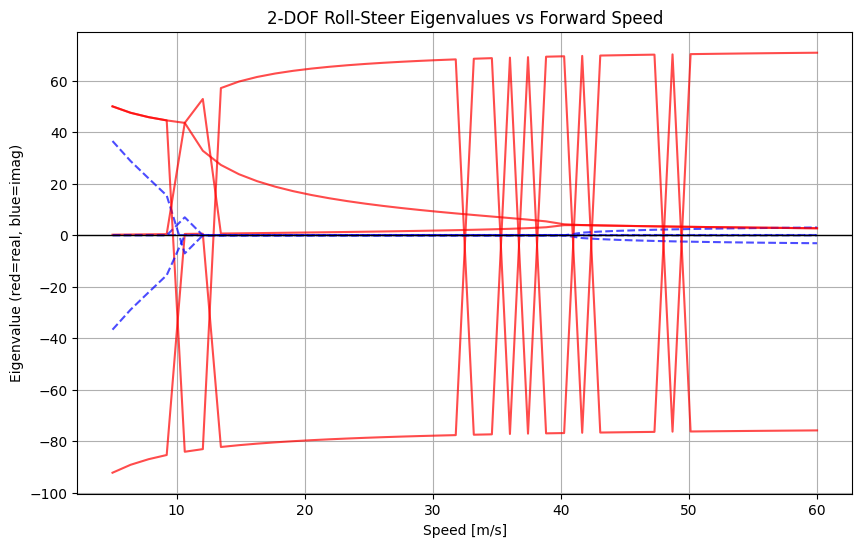

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, eig

# === Parameters ===
I_phi = 80.0      # kg m^2
I_delta = 1.0     # kg m^2
h = 0.55          # m
m = 250.0         # kg
g = 9.81          # m/s^2

Cf = 60000.0      # N/rad
Cr = 80000.0      # N/rad
a = 0.7           # m (CG to front)
b = 0.6           # m (CG to rear)
tr = 0.09         # m trail

# Mass matrix
M = np.array([[I_phi, 0],
              [0, I_delta]])

# Gravity stiffness
K_gravity = m * g * h

def matrices_at_speed(v):
    """Return C(v), K(v) for given forward speed v"""
    C = np.array([
        [(Cf*a*h - Cr*b*h)/v, 0],
        [-(Cf*a*tr)/v, 0]
    ])
    K = np.array([
        [K_gravity, Cf*h],
        [0, -Cf*tr]
    ])
    return C, K

def state_matrix(v):
    """Construct the 4x4 state matrix at forward speed v"""
    C, K = matrices_at_speed(v)
    Minv = inv(M)
    Z = np.zeros((2,2))
    I2 = np.eye(2)
    A_top = np.hstack((Z, I2))
    A_bottom = np.hstack((-Minv @ K, -Minv @ C))
    A = np.vstack((A_top, A_bottom))
    return A

# Sweep speeds
speeds = np.linspace(5, 60, 40)  # m/s (18-216 km/h)
eigvals_all = []

for v in speeds:
    A = state_matrix(v)
    eigvals = eig(A)[0]
    eigvals_all.append(eigvals)

eigvals_all = np.array(eigvals_all)  # shape (n_speeds, 4)

# Separate real/imag
real_parts = np.real(eigvals_all)
imag_parts = np.imag(eigvals_all)

# Plot eigenvalues vs speed
plt.figure(figsize=(10,6))
for mode in range(4):
    plt.plot(speeds, real_parts[:,mode], 'r-', alpha=0.7)
    plt.plot(speeds, imag_parts[:,mode], 'b--', alpha=0.7)

plt.axhline(0, color='k', linewidth=1)
plt.xlabel("Speed [m/s]")
plt.ylabel("Eigenvalue (red=real, blue=imag)")
plt.title("2-DOF Roll-Steer Eigenvalues vs Forward Speed")
plt.grid(True)
plt.show()